Let's start by just import statsbomb and getting the data. You don't need to run the functions that retrieve data because I already provide it for you here with the dataset, this dataset has around 50k rows and over a hundred columns, each row is a shot from the statsbomb male football data (The free one), this project will focus on training a model to predict the Expected Goals (xG) of each shot, at first my idea is to use logistic regression built by myself, so I can understand how each feature afects the final output, then we will trya neural network and see which one is better. To measure which one is better I will aproximate which xG was clsoer to what happened (1 for goal, 0 for no goal). Neural network should be better in terms of accuracy but I will like to see Logistic Regression because I want to understand each coefficient, so let's go.

In [2]:
# pip install statsbombpy

In [127]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

warnings.filterwarnings('ignore')

If you want the code to retrieve all the data here it is, I warn you that this code could take more than an hour to retrieve all the data because I didn't wanted to be blocked by Github do to excess of requests.

In [4]:
comps = sb.competitions()
all_comps = comps[comps['competition_gender'] == 'male']

In [5]:
def filter_year(season):

    if int(season[:4]) > 2010:
        return season
    else:
        return 0

all_comps['season_name'] = all_comps['season_name'].apply(filter_year)
all_comps = all_comps[all_comps['season_name'] != 0]

In [ ]:
def get_comp_id(all_comps_df: pd.DataFrame, comp_id_col: str, season_id_col: str) -> list:

    comp_season_ids = []

    for comp_id, season_id in zip(all_comps_df[comp_id_col].values, all_comps_df[season_id_col].values):
        comp_season_ids.append([comp_id, season_id])

    return comp_season_ids


def get_matches_id(all_comps_df: pd.DataFrame, comp_id_col: str, season_id_col: str) -> list:

    comp_season_ids = get_comp_id(all_comps_df, comp_id_col, season_id_col)

    all_matches_ids = []

    for comp_id, season_id in comp_season_ids:
        all_matches_ids.extend(sb.matches(comp_id, season_id)['match_id'].values.tolist())
        time.sleep(2)

    return all_matches_ids

def get_shots(all_comps_df: pd.DataFrame, comp_id_col: str, season_id_col: str) -> pd.DataFrame:

    matches_id = get_matches_id(all_comps_df, comp_id_col, season_id_col)

    all_data = pd.DataFrame()

    try:

        for id in matches_id:

            match_data = sb.events(match_id=id)
            match_data = match_data[match_data['type'] == 'Shot']
            all_data = pd.concat([all_data, match_data], ignore_index=True)
            time.sleep(2)

    except Exception as e:

        print(f'Error on match {id}\n {e}')
        time.sleep(10)

    return all_data

# data = get_shots(all_comps, 'competition_id', 'season_id')

Statsbomb data is great, for each shot it has information about the minute, player, type of shot, type of situation, position of the shot in the pitch using X and Y values and one of the most important ones, the location of each player at the time of the shot, at the time the shot is taken, statsbomb takes a snapshot of all the players on the pitch including information about their exact location. So below this I will mention all the variables I want to build using feature engineering to feed my model.

# Variables for the xG Model

### 1. Geometric Characteristics:

1. Euclidean Distance to Goal (Use the Pythagorean Theorem)
2. Shooting Angle: Calculate the (It will be expressed in degrees)
3. Distance to the Center: abs(40 - y)

### 2. Characteristic Context:

1. Body Part
2. Play Type
3. Shooting Technique
4. First-Time Shot
5. One-on-One

### 3. Advanced Characteristics

1. Defenders between the Ball and the Goal: Calculate a triangle between the ball and two posts and see how many defenders there are.
2. Distance from the nearest defender Close
3. Goalkeeper distance to the ball


Now let's clean the dataset and keep just the features we need.

In [328]:
df = pd.read_csv('Shots_df.csv')

In [329]:
df = df[['match_id', 'location', 'minute', 'period', 'play_pattern', 'position', 'shot_aerial_won', 'shot_body_part', 
         'shot_first_time', 'shot_freeze_frame', 'shot_one_on_one', 'shot_outcome', 'shot_statsbomb_xg',
         'shot_technique', 'shot_type', 'under_pressure', 'shot_open_goal', 'shot_follows_dribble']]

## 1.1 Euclidean Distance

Perfect, now we have the features we need, so the next thing is just building each one of our new features, let's start with the geometric charasteristics. The first one is calculating the distance from the shot to the goal. Of course it is not as easy as substracting 2 numbers, statsbomb shows the position of the shot as an X and Y position, where X is the length of the pitch starting from the shooter's team goal to the other and the Y position is the width where of the pitch the shot was taken. Length goes from 0 to 120 and width goes from 0 to 80. So to calculate the distance between the shot and the goal we have to use the Euclidean distance, the goal position is 120 and 40, 40 because it is the center.

In [330]:
df = df.dropna(subset=['location'])

In [331]:
import ast

df['location'] = [ast.literal_eval(val) for val in df['location']]

In [332]:
def get_euclidean_d(row):

    x = row[0]
    y = row[1]

    ed = np.sqrt((120-x)**2 + (40-y)**2)
    return ed

df['shot_distance'] = df['location'].apply(get_euclidean_d)

In [333]:
df[['location', 'shot_distance']].head(3)

,location,shot_distance
0,"[100.4, 35.1]",20.203218
1,"[114.6, 33.5]",8.450444
2,"[106.2, 55.8]",20.978084


## 1.2 Shot Angle

Now we have to calculate the angle of the shot, when I reffer to the triangle that forms the balland the 2 posts, to do this we need to substract the absolute angles to each post, to be able to do that you have to use the arctan2 function of numpy.

In [334]:
def get_left_angle(row):

    x = row[0]
    y = row[1]

    left_a = np.arctan2(44 - y, 120 - x)

    return left_a

def get_right_angle(row):

    x = row[0]
    y = row[1]

    right_a = np.arctan2(36 - y, 120 - x)

    return right_a


df['left_angle'] = df['location'].apply(get_left_angle)
df['right_angle'] = df['location'].apply(get_right_angle)
df['shot_angle'] = abs(df['left_angle'] - df['right_angle'])

In [335]:
df['shot_angle'].head(3)

0    0.380357
1    0.662204
2    0.254675
Name: shot_angle, dtype: float64

## 1.3. Distance to the Center

Is very important to know how centered was the shot because if the shot was close the xG may increase, but if the shot was very close to the endline of the pitch, the xG may go down.

In [336]:
def get_distance_center(row):

    y = row[1]
    dc = abs(40 - y)

    return dc

df['shot_distance_to_center'] = df['location'].apply(get_distance_center)

In [337]:
df[['location', 'shot_distance_to_center']].head(3)

,location,shot_distance_to_center
0,"[100.4, 35.1]",4.9
1,"[114.6, 33.5]",6.5
2,"[106.2, 55.8]",15.8


## 2.1. Body Part

already in data as "shot_body_part"

## 2.2. Play Type

already in data as "play_pattern"

## 2.3 Shooting Technique

already in data as "shot_technique"

## 2.4. First Time Shot

already in data as "shot_first_time"

## 2.5 Shot one on one

already in data as "shot_one_on_one"

In [338]:
df['shot_first_time'] = df['shot_first_time'].replace(np.nan, False)
df['shot_one_on_one'] = df['shot_one_on_one'].replace(np.nan, False)

## 3.1. Defenders between the Ball and the Goal: 

We are going to calculate a triangle between the ball and the 2 posts and then see how many players are inside that area using baricentric coordenates, one of the key features here is the shot_freeze_frame, so first let's make sure there are not NA inside it.

In [339]:
len(np.where(df['shot_freeze_frame'].isna())[0])

722

In [340]:
df.dropna(subset='shot_freeze_frame', inplace=True)

In [341]:
len(np.where(df['shot_freeze_frame'].isna())[0])

0

In [342]:
df['shot_freeze_frame'] = [ast.literal_eval(val) for val in df['shot_freeze_frame']]

In [343]:
def point_in_triangle(pt, v1, v2, v3):
    """
    Check if point 'pt' is inside the triangle formed by v1, v2, and v3.
    We use the sign method (simplified barycentric technique).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(pt, v1, v2)
    d2 = sign(pt, v2, v3)
    d3 = sign(pt, v3, v1)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)

def calculate_angle_density(row):

    # 1. Get coordenates of the ball
    ball = row['location']
    
    # 2. Define the posts
    post_l = [120, 36]
    post_r = [120, 44]
    
    # 3. Get the Freeze Frame
    freeze_frame = row['shot_freeze_frame']
    
    # If there are no freeze frames, return 0
    if not isinstance(freeze_frame, list):
        return 0
    
    defenders = 0
    
    # 4. Iterate over every player
    for player in freeze_frame:
        
        # We just need players from the opposite team
        if not player['teammate'] and player['position']['name'] != 'Goalkeeper': 
            loc_player = player['location']
            
            # 5. Check if it is inside the triangle
            if point_in_triangle(loc_player, ball, post_l, post_r):
                defenders += 1
                
    return defenders


# Aplicamos la función fila por fila
df['shot_angle_density'] = df.apply(calculate_angle_density, axis=1)

# Verificamos los resultados
print(df[['location', 'shot_angle_density']].head())

        location  shot_angle_density
0  [100.4, 35.1]                   1
1  [114.6, 33.5]                   0
2  [106.2, 55.8]                   1
3  [113.9, 47.4]                   0
4   [89.2, 42.5]                   2


## 3.2. Distance from the nearest defender Close

This feature will tell us how close the closest defender is, for this we are going to measure all the distances from all the opponent players and keep the distance of the defender that was the closest to the ball.

In [344]:
def get_closest_distance(row):

    shorter_dist = float('inf')
    ball_pos = row['location']
    ball_pos_x = ball_pos[0]
    ball_pos_y = ball_pos[1]

    for player in row['shot_freeze_frame']:

        if not player['teammate'] and player['position']['name'] != 'Goalkeeper':
            pos = player['location']
            pos_x = pos[0]
            pos_y = pos[1]
            dist = np.sqrt((ball_pos_x - pos_x)**2 + (ball_pos_y - pos_y)**2)

            if dist < shorter_dist:
                shorter_dist = dist

    if shorter_dist ==  float('inf'):
        return 50

    return shorter_dist


df['closest_defender_distance'] = df.apply(get_closest_distance, axis=1)

## 3.3 Goalkeeper distance to the ball

This one is pretty simple, we just have to calculate the euclidian distance between the goalkeeper and the ball.

In [345]:
def get_goalkeeper_dist(row):

    ball_pos = row['location']
    ball_pos_x = ball_pos[0]
    ball_pos_y = ball_pos[1]
    dist = False

    for player in row['shot_freeze_frame']:

        if not player['teammate'] and player['position']['name'] == 'Goalkeeper':
            pos = player['location']
            pos_x = pos[0]
            pos_y = pos[1]
            dist = np.sqrt((ball_pos_x - pos_x)**2 + (ball_pos_y - pos_y)**2)

    if not dist:
        dist = 0

    return dist


df['goalkeeper_distance_ball'] = df.apply(get_goalkeeper_dist, axis=1)

In [346]:
(df['goalkeeper_distance_ball'] == 0).value_counts()

goalkeeper_distance_ball
False    49245
True        29
Name: count, dtype: int64

There were some values were it was 0, so there was no data, so let's drop them.

In [347]:
df = df[df['goalkeeper_distance_ball'] != 0]

In [348]:
(df['goalkeeper_distance_ball'] == 0).value_counts()

goalkeeper_distance_ball
False    49245
Name: count, dtype: int64

## 4. Another features

### 1. Is striker?

In [349]:
attacking_positions = ['Center Forward', 'Left Wing', 'Right Wing', 
                       'Right Center Forward', 'Left Center Forward',
                       'Secondary Striker']


def get_is_striker(row):

    if row in attacking_positions:
        return 1
    
    return 0

df['is_striker'] = df['position'].apply(get_is_striker)

In [350]:
df['shot_body_part'].unique()

array(['Right Foot', 'Left Foot', 'Head', 'Other'], dtype=object)

With that, we're ready to start creating and training our model, this will be the first part and over the time I will start adding new features or probably doing some feature engineering. One thing about Logistic Regression models is that their predicting features can't be correlated because that could cause Multicolinearity and we don't want that, the idea is using variables that have no relations between them. Another thing I wanted to say is that the Logistic Regression model usually predicts a binary output, but in this case I need the probability of each shot, and that will be the xG. I will use a train/validation/testing split, the training to train, the valdiation to improve and adjust settings using the train data and when it finally outputs something good I will try the model using the test set, so let's do it. First let's select and convert the features we're going to use.

In [355]:
y = (df['shot_outcome'] == 'Goal')
y = y.astype(int)
y = pd.DataFrame(y)
y['shot_statsbomb_xg'] = df['shot_statsbomb_xg']

In [356]:
inputs1 = df[['shot_distance', 'shot_angle', 'shot_distance_to_center', 'shot_angle_density', 
              'closest_defender_distance', 'goalkeeper_distance_ball', 'is_striker']]

In [357]:
inputs1['shot_first_time'] = df['shot_first_time'].astype(int)
inputs1['shot_one_on_one'] = df['shot_one_on_one'].astype(int)

In [358]:
play_pattern_dummies = pd.get_dummies(df['play_pattern'], prefix='play_pattern').astype(int)
shot_technique_dummies = pd.get_dummies(df['shot_technique'], prefix='shot_technique').astype(int)
shot_type_dummies = pd.get_dummies(df['shot_type'], prefix='shot_type').astype(int)
body_part_dummies = pd.get_dummies(df['shot_body_part'], prefix='shot_body_part').astype(int)

In [359]:
inputs1 = pd.concat([inputs1, play_pattern_dummies, shot_technique_dummies, 
                     shot_type_dummies, body_part_dummies], axis=1)

So the way I like to approach multicollinearity is by eliminating the feature that has the least capacity of explaining the target variable. To be able to see that we need to use the mutual information classifier from sklearn, the correlation doesn't do much here, so after getting our most important variables we will see which one of those we should keep based on multicollinearity.

In [361]:
from sklearn.feature_selection import mutual_info_classif

scores = mutual_info_classif(inputs1, y['shot_outcome'])

scores_df = pd.DataFrame(
    {'Features': inputs1.columns,
     'Scores': scores}
).sort_values(by='Scores', ascending=False).reset_index(drop=True)

In [362]:
top_features1 = scores_df.iloc[0:15]['Features'].to_list()

In [363]:
inputs1 = inputs1[top_features1]

In [364]:
correlations1 = inputs1.corr()

correlations1_filt = correlations1[(abs(correlations1) > 0.5) & (abs(correlations1) < 1)]

corrs = {}

for col in correlations1_filt.columns:
    for ind, val in zip(correlations1_filt[col].index, correlations1_filt.values):

        if abs(val[0]) > 0.5 and abs(val[0]) < 1:
            corrs[f'{ind}-{col}'] = np.round(val[0], 2)

In [365]:
correlations1_filt

,goalkeeper_distance_ball,shot_distance,shot_angle,shot_angle_density,shot_type_Open Play,shot_distance_to_center,is_striker,shot_technique_Normal,shot_first_time,shot_body_part_Right Foot,play_pattern_Regular Play,shot_one_on_one,shot_body_part_Left Foot,play_pattern_From Free Kick,play_pattern_From Counter
goalkeeper_distance_ball,NaN,0.961844,-0.678064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_distance,0.961844,NaN,-0.755454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_angle,-0.678064,-0.755454,NaN,NaN,NaN,-0.584074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_angle_density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_type_Open Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_distance_to_center,NaN,NaN,-0.584074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_striker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_technique_Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_first_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_body_part_Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.702726,NaN,NaN


In [366]:
scores_df.iloc[0:15, :]

,Features,Scores
0,goalkeeper_distance_ball,0.042598
1,shot_distance,0.038016
2,shot_angle,0.037723
3,shot_angle_density,0.014079
4,shot_type_Open Play,0.013337
5,shot_distance_to_center,0.012616
6,is_striker,0.009043
7,shot_technique_Normal,0.007852
8,shot_first_time,0.007038
9,shot_body_part_Right Foot,0.006958


I will just keep the feature that gives the most information between the 2.

In [367]:
inputs1 = inputs1.drop(['shot_distance', 'shot_angle', 'shot_body_part_Left Foot'], axis=1)

Perfect, now it's time to divide into training, validation and testing sets.

In [380]:
from sklearn.model_selection import train_test_split

X_train1, X_valtest1, y_train1, y_valtest1 = train_test_split(inputs1, y, test_size=0.4, random_state=1, stratify=y['shot_outcome'])
X_test1, X_val1, y_test1, y_val1 = train_test_split(X_valtest1, y_valtest1, test_size=0.5, random_state=1, stratify=y_valtest1['shot_outcome'])

Let's train the model, see how good is classifying and then measure how off are we from the xg that statsbomb provides.

In [419]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

LR = LogisticRegression()

LR.fit(X_train1, y_train1['shot_outcome'])
pred_val1 = LR.predict(X_val1)

print(classification_report(y_val1['shot_outcome'], pred_val1))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8892
           1       0.31      0.01      0.02       957

    accuracy                           0.90      9849
   macro avg       0.60      0.50      0.49      9849
weighted avg       0.85      0.90      0.86      9849



In [385]:
xg_pred1 = LR.predict_proba(X_val1)[:, 1]

So it's time to measure how good or how bad or good the model is when giving the Expected Goals (xG) from a shot, let's see it's dsitribution.

Text(0.5, 1.0, 'Histogram for errors')

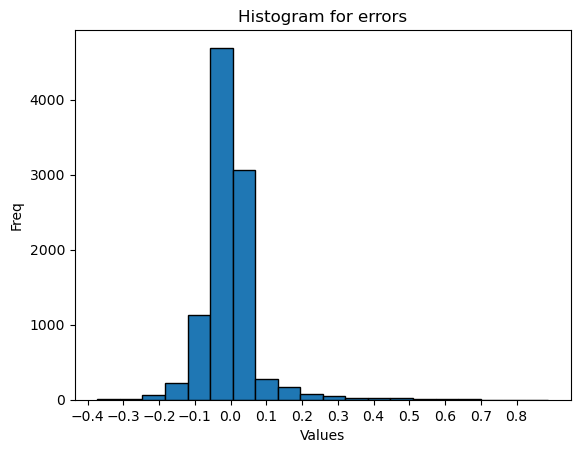

In [416]:
plt.hist(y_val1['shot_statsbomb_xg'] - xg_pred1, bins=20, edgecolor='black')
plt.xticks(np.arange(-0.4, 0.81, 0.1))
plt.xlabel("Values")
plt.ylabel("Freq")
plt.title("Histogram for errors")

In [400]:
X_train1.shape[0]

29547

So around 30 or 40% of our predictions on xG are off by 0.1, which is pretty decent in my opinion, but there is something that is worth investigating. There are a few predictions that are off by over 0.5, which means it is a big mistake. The next step is taking a look in which type of shots the model is making that big of a mistake and tackling that, I will also analyze how each feature affects the target.

In [ ]:
# df['shot_aerial_won'] = df['shot_aerial_won'].replace(np.nan, 0).astype(int)
# df['shot_first_time'] = df['shot_first_time'].astype(int)
# df['shot_one_on_one'] = df['shot_one_on_one'].astype(int)
# df['shot_open_goal] = df['shot_open_goal].astype(int)

shot_aerial_won
0    44905
1     4340
Name: count, dtype: int64